In [15]:
import datetime
import requests
import pandas as pd
import time
import datetime

import math
import calendar
from typing import List, Tuple
import matplotlib.pyplot as plt


In [17]:
latitude = -1.8048
longitude = 37.6200

raw_start_date = "2023-01-01"
raw_end_date   = "2025-09-30"
timezone = "Africa/Nairobi"
output_csv = "makueni_weather_2023_2025.csv"

In [19]:
def normalize_date_string(d: str) -> datetime.date:
    """Convert a string to a date; if day is invalid (e.g. 2025-09-31), clamp to last day of that month."""
    parts = d.split("-")
    if len(parts) != 3:
        raise ValueError("Date must be YYYY-MM-DD")
    y, m, day = int(parts[0]), int(parts[1]), int(parts[2])
    # clamp month -> 1..12
    m = max(1, min(12, m))
    # find last day of month
    last_day = calendar.monthrange(y, m)[1]
    day = max(1, min(last_day, day))
    return datetime.date(y, m, day)

start_date = normalize_date_string(raw_start_date)
end_date   = normalize_date_string(raw_end_date)

today = datetime.date.today()

api_latest = datetime.date(2025, 11, 19) 
max_allowed = min(today, api_latest)

if end_date > max_allowed:
    print(f"end_date {end_date} is after API max {max_allowed}. Clamping to {max_allowed}.")
    end_date = max_allowed

if start_date < datetime.date(1940, 1, 1):
    print("start_date is before 1940-01-01 — clamping to 1940-01-01")
    start_date = datetime.date(1940, 1, 1)

if start_date > end_date:
    raise ValueError(f"start_date {start_date} is after end_date {end_date}")

print("Using date range:", start_date, "→", end_date)


Using date range: 2023-01-01 → 2025-09-30


In [21]:
def split_date_range(start: datetime.date, end: datetime.date, max_days: int = 365) -> List[Tuple[datetime.date, datetime.date]]:
    chunks = []
    current_start = start
    while current_start <= end:
        current_end = min(end, current_start + datetime.timedelta(days=max_days-1))
        chunks.append((current_start, current_end))
        current_start = current_end + datetime.timedelta(days=1)
    return chunks

chunks = split_date_range(start_date, end_date, max_days=365)
print("Will fetch in", len(chunks), "chunk(s):", chunks)


Will fetch in 3 chunk(s): [(datetime.date(2023, 1, 1), datetime.date(2023, 12, 31)), (datetime.date(2024, 1, 1), datetime.date(2024, 12, 30)), (datetime.date(2024, 12, 31), datetime.date(2025, 9, 30))]


In [23]:
def fetch_chunk(lat, lon, sdate: datetime.date, edate: datetime.date, timezone="Africa/Nairobi", max_retries=3, backoff=2):
    base = "https://archive-api.open-meteo.com/v1/archive"
    daily_vars = ",".join([
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "precipitation_sum",
        "relative_humidity_2m_mean",
        "wind_speed_10m_max",
        "cloudcover_mean"
    ])
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": sdate.strftime("%Y-%m-%d"),
        "end_date":   edate.strftime("%Y-%m-%d"),
        "daily": daily_vars,
        "timezone": timezone
    }
    for attempt in range(1, max_retries+1):
        try:
            r = requests.get(base, params=params, timeout=30)
            r.raise_for_status()
            payload = r.json()
            # Basic validation
            if "daily" not in payload or "time" not in payload["daily"]:
                raise ValueError("API response missing expected daily/time fields.")
            return payload
        except Exception as e:
            print(f"Attempt {attempt} failed: {e}")
            if attempt == max_retries:
                raise
            time.sleep(backoff ** attempt)

In [25]:
#all chunks and assemble into a single DataFrame
dfs = []
for s, e in chunks:
    print("Fetching", s, "→", e)
    payload = fetch_chunk(latitude, longitude, s, e, timezone=timezone)
    daily = payload["daily"]
    df_chunk = pd.DataFrame({
        "date": daily["time"],
        "temp_max": daily.get("temperature_2m_max"),
        "temp_min": daily.get("temperature_2m_min"),
        "temp_mean": daily.get("temperature_2m_mean"),
        "humidity_mean": daily.get("relative_humidity_2m_mean"),
        "rainfall_mm": daily.get("precipitation_sum"),
        "wind_speed_max": daily.get("wind_speed_10m_max"),
        "cloud_cover_percent": daily.get("cloudcover_mean"),
    })
    dfs.append(df_chunk)
    # polite pause (avoid rate-limits)
    time.sleep(1)

# concatenate & convert date column
df = pd.concat(dfs, ignore_index=True)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
print("Total rows:", df.shape[0])
df.head()

Fetching 2023-01-01 → 2023-12-31
Fetching 2024-01-01 → 2024-12-30
Fetching 2024-12-31 → 2025-09-30
Total rows: 1004


,date,temp_max,temp_min,temp_mean,humidity_mean,rainfall_mm,wind_speed_max,cloud_cover_percent
0,2023-01-01,27.8,15.1,21.0,59,0.0,16.9,16
1,2023-01-02,26.0,15.4,20.0,64,1.1,18.0,34
2,2023-01-03,26.1,16.0,20.2,71,2.3,17.3,53
3,2023-01-04,25.2,15.7,19.9,77,6.7,17.8,55
4,2023-01-05,26.3,14.3,20.1,70,0.8,17.6,31


In [27]:
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1004 non-null   datetime64[ns]
 1   temp_max             1004 non-null   float64       
 2   temp_min             1004 non-null   float64       
 3   temp_mean            1004 non-null   float64       
 4   humidity_mean        1004 non-null   int64         
 5   rainfall_mm          1004 non-null   float64       
 6   wind_speed_max       1004 non-null   float64       
 7   cloud_cover_percent  1004 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 62.9 KB
None
                                date     temp_max     temp_min    temp_mean  \
count                           1004  1004.000000  1004.000000  1004.000000   
mean   2024-05-16 12:00:00.000000256    27.114542    16.172908    21.196813   
min         

Saved CSV: makueni_weather_2023_2025.csv


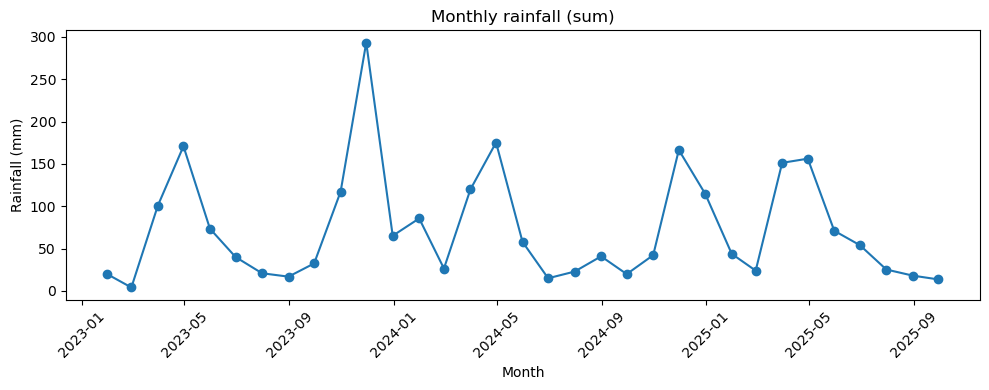

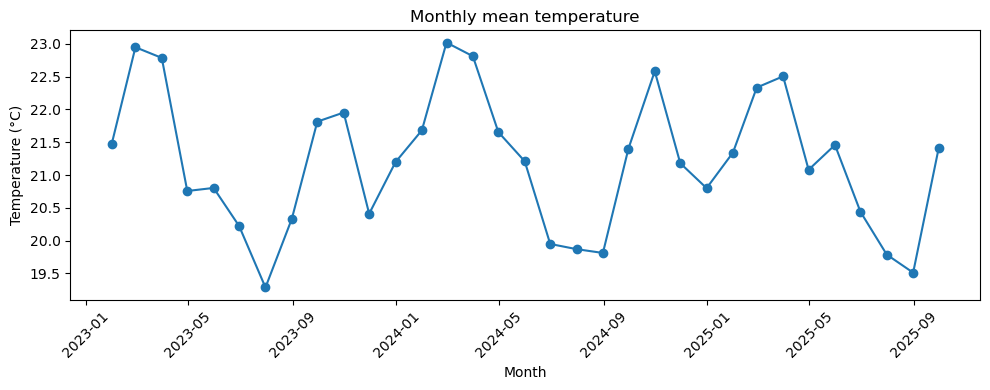

In [17]:
df.to_csv(output_csv, index=False)
print("Saved CSV:", output_csv)

#monthly rainfall and monthly mean temperature
df_month = df.set_index("date").resample("ME").agg({
    "rainfall_mm": "sum",
    "temp_mean": "mean",
    "humidity_mean": "mean"
}).reset_index()

#rainfall 
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_month["date"], df_month["rainfall_mm"], marker='o')
ax.set_title("Monthly rainfall (sum)")
ax.set_xlabel("Month")
ax.set_ylabel("Rainfall (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#monthly mean temperature
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_month["date"], df_month["temp_mean"], marker='o')
ax.set_title("Monthly mean temperature")
ax.set_xlabel("Month")
ax.set_ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
df.to_csv(output_csv, index=False)
print("Saved CSV:", output_csv)

Saved CSV: makueni_weather_2023_2025.csv


In [33]:
import sys
print(sys.executable)

C:\Users\USER\anaconda3\python.exe


In [37]:
import ee
ee.Authenticate()

Enter verification code:  4/1Ab32j93usW1DkFUyS6lG6BaK94ov6tm5ihG6kngq8opD-Hece5jhV-GJd4U



Successfully saved authorization token.


In [55]:
import ee
ee.Initialize()

In [5]:
import ee
import pandas as pd

ee.Initialize()

point = ee.Geometry.Point([37.6200, -1.8048])

modis = ee.ImageCollection("MODIS/061/MOD13Q1") \
            .select('NDVI') \
            .filterDate('2023-01-01', '2025-09-30') \
            .filterBounds(point)

def extract_ndvi(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=250
    ).get('NDVI')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {
        'date': date,
        'ndvi_mean': mean
    })

ndvi_fc = modis.map(extract_ndvi).getInfo()

records = [f['properties'] for f in ndvi_fc['features']]
df_ndvi = pd.DataFrame(records)

df_ndvi['ndvi_mean'] = df_ndvi['ndvi_mean'].astype(float) / 10000

# Save to CSV
df_ndvi.to_csv("makueni_ndvi_2023_2025.csv", index=False)

df_ndvi.head(), df_ndvi.shape

(         date  ndvi_mean
 0  2023-01-01     0.6484
 1  2023-01-17     0.6086
 2  2023-02-02     0.5617
 3  2023-02-18     0.3985
 4  2023-03-06     0.3834,
 (63, 2))

In [9]:
import pandas as pd

#Loading both datasets
df_weather = pd.read_csv("makueni_weather_2023_2025.csv")
df_ndvi = pd.read_csv("makueni_ndvi_2023_2025.csv")

#Convert to datetime to avoid merge issues
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])

#Merge by date
df_merged = pd.merge(df_weather, df_ndvi, on='date', how='left')

#Sort by date
df_merged = df_merged.sort_values(by='date')

#Save final combined dataset
output_path = r"C:\Users\USER\Desktop\makueni_weather_ndvi_2023_2025.csv"
df_merged.to_csv(output_path, index=False)

df_merged.head(), df_merged.shape


(        date  temp_max  temp_min  temp_mean  humidity_mean  rainfall_mm  \
 0 2023-01-01      27.8      15.1       21.0             59          0.0   
 1 2023-01-02      26.0      15.4       20.0             64          1.1   
 2 2023-01-03      26.1      16.0       20.2             71          2.3   
 3 2023-01-04      25.2      15.7       19.9             77          6.7   
 4 2023-01-05      26.3      14.3       20.1             70          0.8   
 
    wind_speed_max  cloud_cover_percent  ndvi_mean  
 0            16.9                   16     0.6484  
 1            18.0                   34        NaN  
 2            17.3                   53        NaN  
 3            17.8                   55        NaN  
 4            17.6                   31        NaN  ,
 (1004, 9))

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("makueni_weather_ndvi_2023_2025.csv")

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,temp_max,temp_min,temp_mean,humidity_mean,rainfall_mm,wind_speed_max,cloud_cover_percent,ndvi_mean
0,2023-01-01,27.8,15.1,21.0,59,0.0,16.9,16,0.6484
1,2023-01-02,26.0,15.4,20.0,64,1.1,18.0,34,NaN
2,2023-01-03,26.1,16.0,20.2,71,2.3,17.3,53,NaN
3,2023-01-04,25.2,15.7,19.9,77,6.7,17.8,55,NaN
4,2023-01-05,26.3,14.3,20.1,70,0.8,17.6,31,NaN


In [29]:
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import os

out_dir = "."
os.makedirs(out_dir, exist_ok=True)

start_date = "2025-01-01"
end_date = "2025-09-30"
freq = "7D"  # weekly sampling

hive_ids = ["Hive-A", "Hive-B", "Hive-C", "Hive-D"]

#queen ages in months
queen_age_start = {
    "Hive-A": 8,   
    "Hive-B": 15,
    "Hive-C": 4,
    "Hive-D": 20
}

# Seed for reproducibility
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# Helper to compute months elapsed since Jan 2025 (0 for Jan)
def months_elapsed(date_obj):
    return (date_obj.year - 2025) * 12 + (date_obj.month - 1)

# Create weekly dates
dates = pd.date_range(start=start_date, end=end_date, freq=freq)

rows = []
for d in dates:
    m_elapsed = months_elapsed(d)
    month = d.month

# Seasonal modulation: create simple month-based multipliers for nectar
# typical avocado/mango/prosopis/flowering seasons referenced in literature for Kenya.
# Jan-Mar: some flowering (multiplier 1.0)
# Apr-Jun: dry season/less forage in some areas (0.9)
# Jul-Aug: minor flowering (1.05)
# Sep: avocado/mango flowering peaks in some regions (1.2)
    if month in [1,2,3]:
        season_mul = 1.00
    elif month in [4,5,6]:
        season_mul = 0.90
    elif month in [7,8]:
        season_mul = 1.05
    elif month == 9:
        season_mul = 1.20
    else:
        season_mul = 1.00

    for h in hive_ids:
# Base parameters per hive
        base_yield = {"Hive-A": 2.8, "Hive-B": 3.2, "Hive-C": 2.2, "Hive-D": 3.0}[h]
        base_colony = {"Hive-A": 30000, "Hive-B": 42000, "Hive-C": 25000, "Hive-D": 48000}[h]
        base_brood = {"Hive-A": 1500, "Hive-B": 2000, "Hive-C": 1200, "Hive-D": 2100}[h]
        base_weight = {"Hive-A": 33, "Hive-B": 36, "Hive-C": 30, "Hive-D": 38}[h]

# Honey yield (kg) for the week: seasonal * base + random noise.
# Ensures yields are non-negative.
        noise = rng.normal(0, 0.9)
        honey_yield_kg = max(0.0, round(base_yield * season_mul + noise, 2))

# Colony size
        colony_size = int(max(6000, base_colony + rng.integers(-5000, 8000)))

# Brood area in cm^2
        brood_area_cm2 = int(max(300, base_brood + rng.integers(-500, 800)))

# Queen age progression in months
        queen_age_months = queen_age_start[h] + m_elapsed

 # Varroa infestation percent
        # (varroa often increases with brood availability; we'll tie to brood area)
        varroa_base = 1.5 + (brood_area_cm2 / 3000.0)  # this gives ~1.5 - 2.5 range
        # Add random noise, and cap at 20%
        varroa_pct = round(min(20.0, abs(rng.normal(varroa_base, 1.2))), 2)

# Nosema presence (0/1): random but slightly more likely in wetter months (Apr-Jun)
        nosema_prob = 0.06
        if month in [4,5,6]:
            nosema_prob = 0.12
        nosema_present = int(rng.random() < nosema_prob)

# American foulbrood presence rare
        afb_prob = 0.015
        afb_present = int(rng.random() < afb_prob)

# Small hive beetle count: more likely in warm/wet months
        if month in [3,4,5,11,12]:
            shb_count = int(max(0, rng.integers(0, 8)))
        else:
            shb_count = int(max(0, rng.integers(0, 3)))

# Hive weight (kg) approximate current weight with some noise
        hive_weight_kg = round(base_weight + rng.normal(0, 3), 2)

# Feeding done (0/1)more feeding in dry months (Apr-Jun)
        feed_prob = 0.08
        if month in [4,5,6]:
            feed_prob = 0.25
        feeding_done = int(rng.random() < feed_prob)
#Stress levels
        stress = "none"
        if varroa_pct > 7.0 and rng.random() < 0.6:
            stress = "pest_pressure"
        elif nosema_present and rng.random() < 0.5:
            stress = "disease_outbreak"
        elif feeding_done == 1 and season_mul < 1.0 and rng.random() < 0.3:
            stress = "drought_stress"
        elif rng.random() < 0.02:
            stress = "queen_failure"

        note = ""
        if stress != "none":
            note = f"{stress}; varroa={varroa_pct}%; shb={shb_count}"

        rows.append({
            "date": d.strftime("%Y-%m-%d"),
            "hive_id": h,
            "honey_yield_kg": honey_yield_kg,
            "colony_size": colony_size,
            "brood_area_cm2": brood_area_cm2,
            "queen_age_months": queen_age_months,
            "varroa_pct": varroa_pct,
            "nosema_present": nosema_present,
            "afb_present": afb_present,
            "shb_count": shb_count,
            "hive_weight_kg": hive_weight_kg,
            "feeding_done": feeding_done,
            "stress_event": stress,
            "note": note
        })

# Save hive logs CSV
hive_df = pd.DataFrame(rows)
hive_csv_path = os.path.join(out_dir, "hive_logs_2025_jan_sep.csv")
hive_df.to_csv(hive_csv_path, index=False)
print("Saved:", hive_csv_path)
print(hive_df.head())

#A simple floral calendar for Makueni
#The months are integers 1..12 mark typical months where the species flowers in Kenya/Makueni region.
#Sources: KEPHIS, avocado flowering studies in Kenya, local agriculture pages, ethnobotanical literature
floral_calendar = [
    {"species": "Avocado (Persea americana)", "common_name": "Avocado", "flowering_months": "2-5,8-10", 
     "notes": "Two flowering seasons observed in Kenya: Feb–May and Aug–Oct (peak months include Mar & Sep)."},
    {"species": "Mango (Mangifera indica)", "common_name": "Mango", "flowering_months": "9-12",
     "notes": "Main mango seasons in Makueni typically peak around Oct–Dec (regional variation)."},
    {"species": "Prosopis juliflora (Prosopis)", "common_name": "Prosopis", "flowering_months": "1-4",
     "notes": "Invasive species; provides nectar/pollen in some dryland areas."},
    {"species": "Acacia spp. (e.g., Acacia mellifera)", "common_name": "Acacia", "flowering_months": "6-10",
     "notes": "Various acacia species flower at different times; important dryland nectar sources."},
    {"species": "Dombeya torrida", "common_name": "Dombeya", "flowering_months": "9-11",
     "notes": "Reported as an important melliferous species in East Africa."},
    {"species": "Grevillea robusta", "common_name": "Grevillea", "flowering_months": "1-3,8-10",
     "notes": "Common agroforestry tree used as windbreaks; nectar source."},
    {"species": "Maize (Flowering maize as pollen source)", "common_name": "Maize", "flowering_months": "10-12",
     "notes": "Flowering maize supplies pollen rather than nectar; seasonal with cropping calendars."},
]

floral_df = pd.DataFrame(floral_calendar)
floral_csv_path = os.path.join(out_dir, "floral_calendar_makueni.csv")
floral_df.to_csv(floral_csv_path, index=False)
print("Saved floral calendar:", floral_csv_path)


Saved: .\hive_logs_2025_jan_sep.csv
         date hive_id  honey_yield_kg  colony_size  brood_area_cm2  \
0  2025-01-01  Hive-A            3.07        33509            1570   
1  2025-01-01  Hive-B            2.43        49683            2150   
2  2025-01-01  Hive-C            1.34        31157            1775   
3  2025-01-01  Hive-D            3.48        55619            2247   
4  2025-01-08  Hive-A            3.35        35343            1246   

   queen_age_months  varroa_pct  nosema_present  afb_present  shb_count  \
0                 8        2.92               0            0          1   
1                15        3.15               0            0          1   
2                 4        2.03               0            0          0   
3                20        2.74               0            0          0   
4                 8        1.78               0            0          1   

   hive_weight_kg  feeding_done stress_event note  
0           33.38             0         

In [57]:
import pandas as pd

# Load datasets
hive = pd.read_csv("hive_logs_2025_jan_sep.csv")
weather = pd.read_csv("makueni_weather_ndvi_2023_2025.csv")

# Convert dates to datetime
hive["date"] = pd.to_datetime(hive["date"])
weather["date"] = pd.to_datetime(weather["date"])

# Merge hive + weather
merged = pd.merge(hive, weather, on="date", how="left")

# Save
merged.to_csv("merged_hive_weather_2025.csv", index=False)

merged.head()


,date,hive_id,honey_yield_kg,colony_size,brood_area_cm2,queen_age_months,varroa_pct,nosema_present,afb_present,shb_count,...,stress_event,note,temp_max,temp_min,temp_mean,humidity_mean,rainfall_mm,wind_speed_max,cloud_cover_percent,ndvi_mean
0,2025-01-01,Hive-A,3.07,33509,1570,8,2.92,0,0,1,...,none,NaN,26.0,16.7,21.0,75,0.2,15.8,30,0.7218
1,2025-01-01,Hive-B,2.43,49683,2150,15,3.15,0,0,1,...,none,NaN,26.0,16.7,21.0,75,0.2,15.8,30,0.7218
2,2025-01-01,Hive-C,1.34,31157,1775,4,2.03,0,0,0,...,none,NaN,26.0,16.7,21.0,75,0.2,15.8,30,0.7218
3,2025-01-01,Hive-D,3.48,55619,2247,20,2.74,0,0,0,...,none,NaN,26.0,16.7,21.0,75,0.2,15.8,30,0.7218
4,2025-01-08,Hive-A,3.35,35343,1246,8,1.78,0,0,1,...,none,NaN,26.8,15.3,21.2,63,0.0,11.6,44,NaN


In [59]:
import pandas as pd

# Floral calendar Jan–Sep 2025
data = {
    "date": [
        "2025-01-15","2025-02-15","2025-03-15","2025-04-15",
        "2025-05-15","2025-06-15","2025-07-15","2025-08-15","2025-09-15"
    ],
    "major_flowers": [
        "Acacia tortilis, Mango, Commiphora",
        "Acacia tortilis, Acacia mellifera, Mango",
        "Croton, Acacia mellifera",
        "Croton, Melia volkensii",
        "Citrus, Croton",
        "Aloe, Citrus",
        "Aloe, Pasture weeds",
        "Eucalyptus, Pasture weeds",
        "Eucalyptus camaldulensis"
    ],
    "nectar_flow_strength": [
        "High","High","Medium","Medium","Medium","Medium","Low","Low-Medium","High"
    ],
    "stress_risk": [
        "Low","Low","Medium","Low","Medium","Medium","High","High","Low"
    ],
    "pest_disease_notes": [
        "Hive beetles active",
        "Wax moth pressure",
        "Varroa buildup",
        "Chalkbrood risk",
        "Nosema risk",
        "Slow brood buildup",
        "Ant invasions",
        "Weak colony pests",
        "Healthy buildup"
    ]
}

floral = pd.DataFrame(data)
floral["date"] = pd.to_datetime(floral["date"])
floral


,date,major_flowers,nectar_flow_strength,stress_risk,pest_disease_notes
0,2025-01-15,"Acacia tortilis, Mango, Commiphora",High,Low,Hive beetles active
1,2025-02-15,"Acacia tortilis, Acacia mellifera, Mango",High,Low,Wax moth pressure
2,2025-03-15,"Croton, Acacia mellifera",Medium,Medium,Varroa buildup
3,2025-04-15,"Croton, Melia volkensii",Medium,Low,Chalkbrood risk
4,2025-05-15,"Citrus, Croton",Medium,Medium,Nosema risk
5,2025-06-15,"Aloe, Citrus",Medium,Medium,Slow brood buildup
6,2025-07-15,"Aloe, Pasture weeds",Low,High,Ant invasions
7,2025-08-15,"Eucalyptus, Pasture weeds",Low-Medium,High,Weak colony pests
8,2025-09-15,Eucalyptus camaldulensis,High,Low,Healthy buildup


In [61]:
merged = (
    hive
    .merge(weather, on="date", how="left")
    .merge(floral, on="date", how="left")
)

merged.to_csv("merged_hive_weather_floral_2025.csv", index=False)

In [63]:
floral.to_csv("makueni_floral_calendar_2025.csv", index=False)

print("Floral calendar saved as 'makueni_floral_calendar_2025.csv'")

Floral calendar saved as 'makueni_floral_calendar_2025.csv'
